In [1]:
import pandas as pd
import numpy as np
import sys; sys.path.append("..")
from trader.data.binance import Binance
import copy

In [2]:
b = Binance(test=False)

In [50]:
bars = b.get_bars(["BTCUSDT", "ETHUSDT"], pd.to_datetime("2022-06-15"), pd.to_datetime("2022-06-20"), interval="1h")
#bars = bars[bars.Symbol.isin(["BTCUSDT"])]
bars.head()

,OpenTime,Open,High,Low,Close,Volume,CloseTime,QuoteVolume,NumTrades,TakerBaseVolume,TakerQuoteVolue,Return,Symbol
0,2022-06-15 01:00:00,21808.33,22297.37,21770.68,22163.99,4223.391930,2022-06-15 02:00:00,9.315152e+07,60399,2141.62233,4.723347e+07,NaN,BTCUSDT
1,2022-06-15 02:00:00,22164.00,22174.98,21851.39,21985.86,2756.334310,2022-06-15 03:00:00,6.060307e+07,46023,1229.01238,2.701681e+07,-0.008037,BTCUSDT
2,2022-06-15 03:00:00,21985.85,22044.44,21406.68,21455.80,4638.985750,2022-06-15 04:00:00,1.006310e+08,67481,2025.74196,4.392856e+07,-0.024109,BTCUSDT
3,2022-06-15 04:00:00,21455.80,21490.67,20923.51,21148.79,11547.412450,2022-06-15 05:00:00,2.440190e+08,137208,5303.51036,1.121084e+08,-0.014309,BTCUSDT
4,2022-06-15 05:00:00,21148.80,21350.00,20750.00,21226.31,8756.798933,2022-06-15 06:00:00,1.844812e+08,116623,4039.36487,8.516578e+07,0.003665,BTCUSDT


In [56]:
data = {}
for symbol, grp in bars.groupby("Symbol"):
    grp = grp.set_index("CloseTime")[["Close", "Volume"]]
    grp.index = pd.to_datetime(grp.index)
    data[symbol] = grp
index = pd.date_range("2022-06-15 12:00:00", "2022-06-20", freq="1h")

In [57]:
def cp_meanrev(price, window, sigma, trade_on=0):
    if price.shape[0] < window:
        return None
    mean = price.iloc[-window:].mean()
    std = price.diff().iloc[-window:].std()
    if (price.iloc[-1] < mean - std*sigma) and (trade_on == 0):
        return 1
    elif (price.iloc[-1] > mean) and (trade_on > 0):
        return 0
    else:
        return trade_on

In [58]:
def cp_trend(price, window, trade_on=0):
    if price.shape[0] < window*8:
        return None
    r1 = np.sign(price.iloc[-1]/price.iloc[-window*8] -1)
    r2 = np.sign(price.iloc[-1]/price.iloc[-window*4] -1)
    r3 = np.sign(price.iloc[-1]/price.iloc[-window] -1)
    signal = (r1+r2+r3)/3.0
    if signal > 0:
        return 1
    else:
        return 0
    return signal

In [59]:
class Backtest:
    def __init__(self, data, index, state={}):
        self.data = data
        self.index = index
        self.state = state
        self.states = []
        
        
    def initialize(self):
        symbols = list(self.data.keys())
        currs = []
        for s in symbols:
            c1, c2 = s[:3], s[3:]
            currs.extend([c1,c2])
        currs = np.unique(currs)
        self.state["positions"] = {k:0 for k in currs}
        self.state["positions"]["USDT"] = 100
        self.state["trades_on"] = {k:0 for k in symbols}
        self.state["prices"] = {k : data[k].Close.loc[self.index[0]] for k in symbols}
        self.state["date"] = self.index[0]
    
    def get_fx(self, symbol):
        #TODO: implement
        return 1
        
    def order(self, symbol, quote_size=0, base_size=0, fx=None):
        #TODO: ADD FEE
        base = symbol[:3] #NEED TO FIX, CAN BE MORE THAN 3.
        quote = symbol[3:] #NEED TO FIX
        if fx is None:
            fx = self.get_fx(symbol)
        if (quote_size == 0) & (base_size != 0):
            quote_size = base_size * fx
        elif (quote_size != 0) & (base_size == 0):
            base_size = quote_size / fx
        self.state["positions"][base] += base_size
        self.state["positions"][quote] -= quote_size
    
    def step(self, t):
        self.state["date"] = t
        for s in self.data.keys():
            price = self.data[s].Close.loc[:t]
            self.state["prices"][s] = price.iloc[-1]
            trade_on = self.state["trades_on"][s]
            #signal = cp_meanrev(price, 30, 1.5, trade_on)
            signal = cp_trend(price, 5)
            if trade_on != signal:
                quote_size = 0.5 * self.state["positions"][s[3:]]
                self.order(s, quote_size=quote_size, fx = price.iloc[-1])
                self.state["trades_on"][s] = signal
        self.states.append(copy.deepcopy(self.state))
            
            
    
    def run(self):
        for i,t in enumerate(self.index):
            if i < 30:
                continue
            self.step(t)

In [60]:
bt = Backtest(data, index)
bt.initialize()

In [61]:
bt.run()

In [62]:
pd.DataFrame(bt.state)

,positions,trades_on,prices,date
BTC,0.003169,NaN,NaN,2022-06-20
ETH,0.030795,NaN,NaN,2022-06-20
USDT,0.000381,NaN,NaN,2022-06-20
BTCUSDT,NaN,1.0,20574.00,2022-06-20
ETHUSDT,NaN,1.0,1128.53,2022-06-20


In [63]:
positions = {}
trades = {}
prices = {}
for state in bt.states:
    date = state["date"]
    positions[date] = state["positions"]
    trades[date] = state["trades_on"]
    prices[date] = state["prices"]

In [64]:
pd.DataFrame(positions).T

,BTC,ETH,USDT
2022-06-16 18:00:00,0.000000,0.000000,100.000000
2022-06-16 19:00:00,0.000000,0.000000,100.000000
2022-06-16 20:00:00,0.000000,0.000000,100.000000
2022-06-16 21:00:00,0.000000,0.000000,100.000000
2022-06-16 22:00:00,0.000000,0.000000,100.000000
...,...,...,...
2022-06-19 20:00:00,0.003169,0.030795,0.000381
2022-06-19 21:00:00,0.003169,0.030795,0.000381
2022-06-19 22:00:00,0.003169,0.030795,0.000381
2022-06-19 23:00:00,0.003169,0.030795,0.000381


<AxesSubplot:>

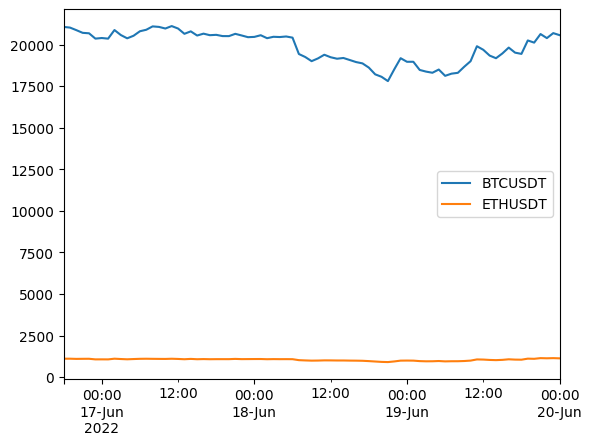

In [65]:
pd.DataFrame(prices).T.plot()

<AxesSubplot:>

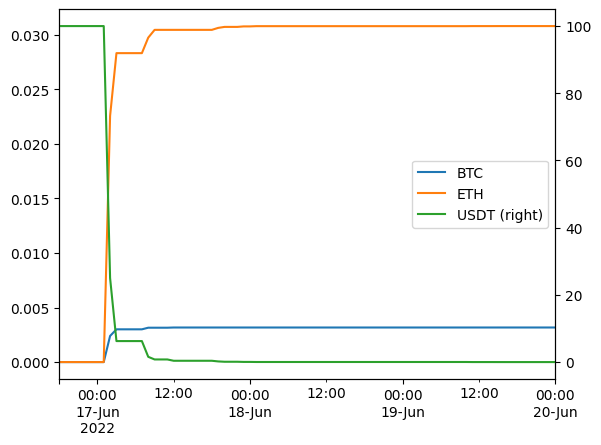

In [66]:
pd.DataFrame(positions).T.plot(secondary_y="USDT")

<AxesSubplot:>

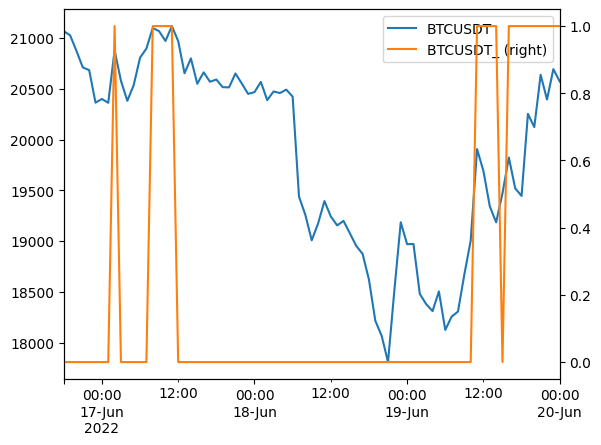

In [67]:
pd.DataFrame(prices).T.join(pd.DataFrame(trades).T, rsuffix="_")[["BTCUSDT", "BTCUSDT_"]].plot(secondary_y = "BTCUSDT_")

<AxesSubplot:>

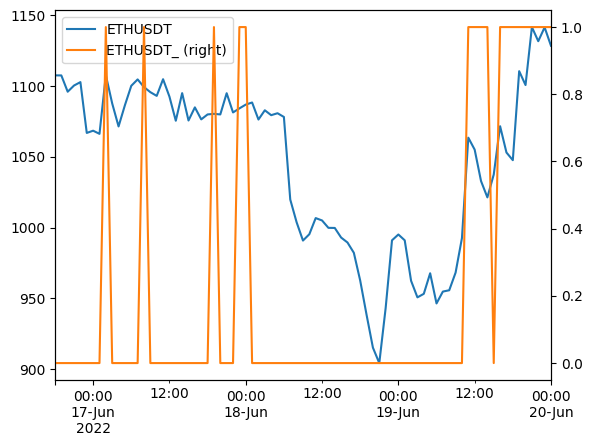

In [68]:
pd.DataFrame(prices).T.join(pd.DataFrame(trades).T, rsuffix="_")[["ETHUSDT", "ETHUSDT_"]].plot(secondary_y = "ETHUSDT_")